# AssurPrime : Saurez-vous prédire la prime d'assurance ?

<p align="center">
  <img src="https://challengedata.ens.fr/logo/public/CA_assurances_RVB_sans-raison-d%C3%AAtre_%C3%A9v%C3%A9nementiel_Mg5WVL6.png" width="350" title="Crédit Agricole Assurances">
</p>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/challengedata_ens_AssurPrime/blob/main/notebooks/exploration/assurprim_modeling_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Contexte

Crédit Agricole Assurances est une filiale du Groupe Crédit Agricole dédiée à l’assurance, faisant de celui-ci un acteur multi-expert de la bancassurance et le 1er bancassureur en Europe.
Crédit Agricole Assurances regroupe plusieurs entités, dont Predica et Pacifica, qui proposent une large gamme d’assurances aux particuliers, aux exploitants agricoles, aux professionnels et aux entreprises. Crédit Agricole Assurances s’engage à offrir des solutions innovantes et adaptées aux besoins des clients, tout en favorisant le développement durable et la responsabilité sociale.
Au sein de l’Académie Data Science du groupe, l’objectif est de participer activement à la montée en compétences des collaborateurs, de partager des connaissances et d’identifier de nouveaux usages.

# Objectif

Le contrat Multirisque Agricole, géré par Pacifica, est souscrit par les agriculteurs pour sécuriser leur exploitation. Il couvre l’activité professionnelle, les dommages aux bâtiments d’exploitation, le matériel stocké, ainsi que la protection financière et juridique. Ce contrat garantit à l’assuré une couverture efficace et durable, assurant ainsi la continuité de son activité en cas de sinistre, tant sur le plan matériel que financier.

Actuellement, le risque d’incendie constitue une part majeure de la charge sinistre du contrat Multirisque Agricole, ce qui en fait un enjeu clé à modéliser avec précision.

L’objectif est d’identifier le meilleur modèle pour prédire la prime pure incendie, en utilisant :
- Un modèle pour la Fréquence,
- Un modèle pour le Coût moyen.

La variable cible finale, la charge, est obtenue en multipliant la fréquence, le coût moyen, et le nombre d’années depuis la souscription du contrat (la variable `ANNEE_ASSURANCE`).

# Description des données

Un fichier supplémentaire est mis à disposition regroupant toutes les variables disponibles, accompagnées de leur description. Ce fichier inclut :

- **Les variables cibles** : `FREQ`, `CM`, et `CHARGE`
- **Données géographiques** : département, données météorologiques, etc.
- **Données spécifiques au contrat**, notamment :
    - L’activité de l’assuré (cultivateur, polyculteur, etc.)
    - Les indicateurs de souscription des garanties
    - Le nombre de bâtiments, de salariés, et de sinistres déclarés lors de la souscription
    - **Données de surface** : surfaces des bâtiments (élevage, exploitation, etc.), anonymisées en `surface1`, `surface2`, etc., pour garantir la confidentialité
    - **Données de capitaux** : capitaux assurés pour différentes options (vol, serres, etc.), anonymisés en `capital1`, `capital2`, etc.
    - **Données liées à la prévention** : présence d’équipements (extincteurs, structure en bois, etc.), anonymisées en `prev1`, `prev2`, etc.


# Description du *benchmark*

## Objectif du challenge

L’objectif de ce challenge est de comparer les performances des modèles développés dans le cadre de cette compétition avec celles d’un modèle de référence basé sur des **GLM (Generalized Linear Models)** classiques.

## Structure du benchmark

Le benchmark repose sur deux modèles **GLM** distincts :

- Fréquence des sinistres :
    - Distribution : *Loi de Poisson* ;
    - Fonction de lien : *Log*.

- Coût moyen d’un sinistre :
    - Distribution : *Tweedie* ;
    - Fonction de lien : *Log*.

## Évaluation

L’évaluation des modèles repose sur une métrique unique : **RMSE (Root Mean Square Error)**, définie par la formule suivante :

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

où :
- $y_i$ représente la valeur réelle ;
- $\hat{y}_i$ représente la valeur prédite ;
- $n$ est le nombre d’observations.

L’idée reste d’évaluer dans quelle mesure les approches proposées permettent de dépasser les performances des modèles standards tout en prenant en compte :

- La précision des prédictions ;
- Les aspects d’interprétabilité et d’efficacité ;
- Les contraintes métier associées.

## Bibliothèques utilisées

Installation et importation des bibliothèques nécessaires à l’analyse, couvrant l’ensemble du processus de traitement des données, de modélisation et d’évaluation :

- `pandas`, `numpy` : manipulation de données numériques et tabulaires ;
- `matplotlib.pyplot`, `seaborn` : visualisation pour l’exploration et l’analyse des résultats ;
- `scipy.stats.chi2_contingency` : test statistique sur les variables qualitatives ;
- `scikit-learn` : imputation (`SimpleImputer`), standardisation (`StandardScaler`), modélisation (régression logistique, ridge, gradient boosting), validation croisée et évaluation des performances (RMSE, F-score, AUC, etc.) ;
- `xgboost` : modélisation via des algorithmes de boosting (`XGBClassifier`, `XGBRegressor`) ;
- `category_encoders.CountEncoder` : encodage des variables catégorielles par fréquence d’apparition ;
- `IPython.display.display` : affichage contrôlé des objets dans le notebook.

In [ ]:
!pip install -q category-encoders \
                matplotlib \
                numpy \
                pandas \
                scikit-learn \
                seaborn \
                xgboost

In [ ]:
from category_encoders import CountEncoder
from pathlib import Path
from IPython.display import display, HTML
from scipy.stats import chi2_contingency
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, fbeta_score, mean_squared_error, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Chargement et aperçu des données

Chargement des fichiers de données d'entraînement à partir des sources distantes. Les fichiers comprennent :

- `X_train` : variables explicatives issues des contrats d’assurance ;
- `y_train` : variables cibles associées (fréquence, coût moyen, charge).

Un aperçu des premières lignes sera ensuite affiché afin de vérifier la structure et le contenu des jeux de données.

In [2]:
# Construction des chemins absolus
local_x_path = Path("../../data/raw/x_train.csv").resolve()
local_y_path = Path("../../data/raw/y_train.csv").resolve()

# URLs distantes
X_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_train.csv"
y_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/y_train.csv"

try:
    print("Chargement des données...")

    # Chargement de X_train
    if local_x_path.exists():
        X_train = pd.read_csv(local_x_path)
        print(f"x_train chargé depuis : {local_x_path}")
    else:
        X_train = pd.read_csv(X_train_url)
        local_x_path.parent.mkdir(parents=True, exist_ok=True)
        X_train.to_csv(local_x_path, index=False)
        print(f"x_train téléchargé et enregistré dans : {local_x_path}")

    # Chargement de y_train
    if local_y_path.exists():
        y_train = pd.read_csv(local_y_path)
        print(f"y_train chargé depuis : {local_y_path}")
    else:
        y_train = pd.read_csv(y_train_url)
        local_y_path.parent.mkdir(parents=True, exist_ok=True)
        y_train.to_csv(local_y_path, index=False)
        print(f"y_train téléchargé et enregistré dans : {local_y_path}")

    print("\nDonnées chargées avec succès.")

except Exception as e:
    print("Échec du chargement des données : vérifier la validité des URL ou la disponibilité de la connexion internet.")
    print(e)

Chargement des données...


C:\Users\Aurel\AppData\Local\Temp\ipykernel_7796\3349736844.py:14: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv(local_x_path)


x_train chargé depuis : \\wsl.localhost\Ubuntu\home\aurelien\workspace\challengedata_ens_AssurPrime\data\raw\x_train.csv
y_train chargé depuis : \\wsl.localhost\Ubuntu\home\aurelien\workspace\challengedata_ens_AssurPrime\data\raw\y_train.csv

Données chargées avec succès.


### Aperçu des variables explicatives (`X_train`)

In [3]:
# aperçu de X_train
print("Aperçu de X_train :")
display(X_train.head())
# Affichage du nombre d'observations
display(f"Nombre d'observations : {len(X_train)}.")

Aperçu de X_train :


,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
1,2,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
2,3,ACT1,VOC6,1,2,N,R,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402740,NaN,ANNEE5,3
3,4,ACT1,VOC6,2,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.246575,NaN,ANNEE5,3
4,5,ACT1,VOC6,2,1,N,N,NaN,NaN,N,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,NaN,ANNEE5,3


"Nombre d'observations : 383610."

Le jeu de données `X_train` contient les variables explicatives issues des contrats d’assurance. Chaque ligne correspond à un contrat souscrit dans le cadre du produit Multirisque Agricole.

Les premières colonnes illustrent la diversité des informations disponibles :

- **Variables catégorielles liées au contrat** (`ACTIVIT2`, `VOCATION`, `TYPERS`, etc.) ;
- **Indicateurs de caractéristiques techniques ou déclaratives** (`CARACT1`, `CARACT2`, etc.) ;
- **Variables météorologiques et historiques** (préfixes `NBJRR`, `RR_VOR`, `RRAB_VOR`, etc.) ;
- **Variables numériques** comme `ANNEE_ASSURANCE`, représentant le nombre d’années depuis la souscription.

Certaines colonnes contiennent des valeurs manquantes ou anonymisées (valeurs encodées ou plages de classes), qu’il conviendra de traiter lors de la phase de prétraitement.

### Aperçu des variables cibles (`y_train`)

In [4]:
print("\nAperçu de y_train :")
display(y_train.head())


Aperçu de y_train :


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,1,0.0,0.0,1.000000,0.0
1,2,0.0,0.0,1.000000,0.0
2,3,0.0,0.0,0.402740,0.0
3,4,0.0,0.0,0.246575,0.0
4,5,0.0,0.0,0.838356,0.0


Le jeu de données `y_train` contient les variables cibles associées à chaque contrat :

- `FREQ` : fréquence des sinistres liés à l’incendie ;
- `CM` : coût moyen des sinistres ;
- `ANNEE_ASSURANCE` : nombre d’années écoulées depuis la souscription du contrat ;
- `CHARGE` : variable cible finale.

Conformément à la définition métier indiquée dans le contexte du projet, la charge est calculée de la manière suivante :

$$
\text{CHARGE} = \text{FREQ} \times \text{CM} \times \text{ANNEE\_ASSURANCE}
$$

Dans l’échantillon présenté, les premières lignes montrent des charges nulles, en lien avec l'absence de sinistres (`FREQ = 0`). Ce déséquilibre devra être pris en compte lors de la modélisation.
Vérifions si ce déséquilibre doit éffectivement pris en compte en calculant le nombre et le pourcentage de lignes avec `FREQ = 0`.

In [5]:
# Calcul du nombre et du pourcentage de lignes avec FREQ nulle
nb_freq_zero = (y_train["FREQ"] == 0).sum()
pourcentage_freq_zero = nb_freq_zero / len(y_train) * 100

print(f"Nombre de lignes avec FREQ = 0 : {nb_freq_zero}")
print(f"Nombre de lignes totales : {len(y_train)}")
print(f"Proportion de FREQ = 0 : {pourcentage_freq_zero:.2f}%")

Nombre de lignes avec FREQ = 0 : 380716
Nombre de lignes totales : 383610
Proportion de FREQ = 0 : 99.25%


### Premiers Constats

- Une très large majorité des contrats présentent une fréquence de sinistres nulle. Plus précisément, **380 716 lignes sur 383 610**, soit **99,25 %** des observations, ont une valeur `FREQ = 0`, conduisant ainsi à une charge nulle (`CHARGE = 0`) ;
- Ce déséquilibre massif indique un phénomène de rareté des sinistres, caractéristique classique des problématiques assurantielles. Il devra être pris en compte lors de la phase de modélisation, notamment en matière de choix d’algorithmes, de métriques d’évaluation ou de stratégie d’échantillonnage ;
- **Des valeurs manquantes** sont présentes dans certaines colonnes, nécessitant un traitement adéquat lors de la phase de prétraitement.

Ces éléments devront être pris en compte pour garantir la robustesse et la pertinence des modèles prédictifs.

## Inspection exploratoire des données

Avant d’engager toute phase de prétraitement ou de modélisation, une inspection exploratoire des données est effectuée afin de mieux comprendre leur structure, leur qualité et leur comportement statistique.

Cette étape permet d’identifier :

- la nature des variables (numériques, catégorielles, booléennes, etc.) ;
- la présence de valeurs manquantes ou aberrantes ;
- les distributions des variables cibles et explicatives ;
- d’éventuels déséquilibres ou effets de rareté dans certaines modalités.

Les constats issus de cette exploration orienteront les choix méthodologiques appliqués dans la suite de l’analyse.

### Typage des variables

L’inspection des types de données permet d’identifier la nature des variables présentes dans le jeu `X_train`. Cette étape est essentielle pour distinguer les variables numériques, catégorielles ou booléennes, et anticiper les traitements appropriés (encodage, normalisation, etc.).

L’affichage complet des types permet également de détecter d’éventuelles incohérences, comme des variables numériques encodées en `object`.

In [6]:
# Création d'une boîte scrollable pour afficher les types de données
scrollable_types = X_train.dtypes.to_frame(name="dtype").to_html()

HTML(f"""
<div style="height:300px; overflow-y:scroll; border:1px solid lightgray; padding:10px">
    {scrollable_types}
</div>
""")

,dtype
ID,int64
ACTIVIT2,object
VOCATION,object
TYPERS,int64
ANCIENNETE,int64
ADOSS,object
CARACT1,object
CARACT2,float64
CARACT3,object
INDEM1,object


Le nombre de variables étant conséquent, affichons-en un résumé pour mieux appréhender leur nature.

### Répartition des types de variables

La répartition des types de colonnes permet d’avoir une vue d’ensemble sur la nature des variables disponibles :

- Les **variables catégorielles** (type `object`) nécessiteront un encodage ;
- Les **variables numériques** (types `int64`, `float64`) peuvent être utilisées directement après traitement des valeurs manquantes.

Cette catégorisation facilite la préparation ciblée des données pour la phase de modélisation.

Ce travail requiert au préalable un regroupement des colonnes selon leur type, ainsi que l’identification explicite des variables appartenant à chaque catégorie.

### Regroupement des colonnes par type

D'une part, affichons un synthèse de la répartition des types en vue d’organiser l’analyse.

In [7]:
print("Répartition des types de variables :")
display(X_train.dtypes.value_counts())

Répartition des types de variables :


object     280
int64       58
float64     36
Name: count, dtype: int64

La répartition des types de variables dans le jeu `X_train` est la suivante :

- **280 variables de type `object`** : ces colonnes correspondent à des données catégorielles ou textuelles, nécessitant un encodage spécifique avant leur utilisation dans les modèles ;
- **58 variables de type `int64`** : généralement des entiers représentant des indicateurs, des comptes, ou des modalités encodées numériquement ;
- **36 variables de type `float64`** : variables numériques continues, souvent associées à des mesures comme des surfaces, des capitaux ou des indicateurs dérivés.

Cette répartition souligne la forte présence de variables catégorielles dans les données, ce qui influencera fortement les choix de prétraitement (encodage, imputation) ainsi que les algorithmes de modélisation à privilégier.

### Liste des colonnes par type

D'autre part, identifions explicitement les variables catégorielles, numériques, etc., informations utiles dans le cadre de l'encodage ou l'imputation.

In [8]:
# Séparation des variables par type
categorical_cols = X_train.select_dtypes(include="object").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

print(f"Nombre de variables catégorielles : {len(categorical_cols)}")
print(f"Nombre de variables numériques : {len(numerical_cols)}")

Nombre de variables catégorielles : 280
Nombre de variables numériques : 94


Au total, **280 variables sont catégorielles** (`object`) et **94 sont numériques** (`int64` et `float64` combinés).

Cette forte proportion de variables catégorielles renforce l’importance d’un encodage adapté pour garantir la bonne prise en compte de l’information dans les modèles. Les variables numériques devront quant à elles faire l’objet d’une vérification des valeurs manquantes, de la distribution et, si nécessaire, d’une standardisation.

## Analyse des valeurs manquantes

L’analyse des valeurs manquantes permet d’évaluer la qualité du jeu de données en identifiant les variables partiellement renseignées. Ces colonnes devront faire l’objet d’un traitement spécifique : suppression, imputation ou méthodes adaptées au contexte.

Pour chaque variable, seront indiqués :

- Le **nombre de valeurs manquantes** ;
- La **proportion de valeurs manquantes** par rapport au total d’observations ;
- Un **tri décroissant** selon cette proportion, afin de faire ressortir les variables les plus concernées.

In [9]:
# Nombre et taux (%) de valeurs manquantes
nb_missing = X_train.isnull().sum()
taux_missing = X_train.isnull().mean() * 100

# DataFrame résumé
missing_info = pd.DataFrame({
    'Valeurs manquantes': nb_missing,
    'Taux (%)': taux_missing.round(2)
})

# Filtrage des colonnes avec au moins une valeur manquante
missing_info = missing_info[missing_info['Valeurs manquantes'] > 0]

# Tri décroissant par taux
missing_info = missing_info.sort_values(by='Taux (%)', ascending=False)

# Affichage dans une boîte scrollable
html_table = missing_info.to_html()
HTML(f"""
<div style="height:300px; overflow-y:scroll; border:1px solid lightgray; padding:10px">
    {html_table}
</div>
""")

,Valeurs manquantes,Taux (%)
DEROG14,383602,100.00
DEROG13,382317,99.66
DEROG16,380358,99.15
CARACT2,368284,96.00
CARACT3,368284,96.00
TYPBAT1,353336,92.11
DEROG12,349078,91.00
BDTOPO_BAT_MAX_HAUTEUR,237385,61.88
HAUTEUR_MAX,237385,61.88
HAUTEUR,237385,61.88


L’analyse met en évidence une proportion importante de variables présentant des taux de valeurs manquantes élevés. Celles-ci se répartissent selon plusieurs niveaux d’impact :

- **Totalement ou quasi totalement manquantes** : `DEROG14` (100%), `DEROG13` (99.66%), `DEROG16` (99.15%)
- **Taux très élevés (> 90%)** : `CARACT2`, `CARACT3`, `TYPBAT1`, `DEROG12`
- **Taux intermédiaires (56-62%)** : variables météo et distances (`RRAB_VOR_MM_A`, `DISTANCE_311`, etc.)
- **Taux modérés (20-40%)** : `RISK13`, `KAPITAL11`, `SURFACE8`, etc.
- **Taux faibles (< 10%)** : `MEN_MAIS`, `RISK1`, `FRCH2`, etc.

### Remarques méthodologiques
- Les variables présentant plus de 90 % de valeurs manquantes sont susceptibles d’être exclues de l’analyse ;
- Certaines familles de variables (distances, météo) présentent une cohérence structurelle, ouvrant la voie à :
  - une **imputation croisée** entre variables similaires ;
  - une **imputation conditionnelle** par regroupements géographiques ou sectoriels ;
  - ou une **réduction de dimension** (agrégation, ACP).

Compte tenu du volume élevé de variables partiellement renseignées, une sélection rigoureuse devra être opérée afin de réduire la dimensionnalité sans perte significative d'information. Les variables manifestement peu informatives, telles que `DEROGnn`, seront probablement exclues.

Un arbitrage spécifique sera réalisé **variable par variable**, selon la cible considérée (`FREQ` ou `CM`). La suite de l’analyse consistera à **quantifier ces taux de manière détaillée**, en vue d’un prétraitement adapté.

Au-delà des valeurs manquantes, la compréhension de la structure des données passe également par l’étude du **nombre de modalités distinctes** par variable. Cette analyse permet d’identifier :

- Les variables constantes, sans pouvoir discriminant ;
- Les variables à cardinalité élevée, nécessitant un encodage adapté ;
- Les colonnes discrètes ou quasi-binaires pouvant influencer les choix de modélisation.

L’objectif est de détecter les variables peu informatives ou problématiques, en vue d’une éventuelle exclusion ou d’un traitement spécifique.

## Analyse du nombre de modalités uniques par variable

Cette section propose un décompte du **nombre de valeurs uniques** pour chaque variable du jeu `X_train`, trié en ordre décroissant. L’interprétation de ces résultats permettra de cibler :

- Les variables constantes à supprimer ;
- Les variables avec un nombre excessif de modalités à encoder spécifiquement ;
- Les cas intermédiaires pouvant orienter vers un regroupement ou une transformation.

In [15]:
# Analyse du nombre de valeurs uniques
unique_values = X_train.nunique().sort_values(ascending=False)

# Affichage dans une boîte scrollable
html_unique = unique_values.to_frame(name="Nombre de valeurs uniques").to_html()
HTML(f"""
<div style="height:300px; overflow-y:scroll; border:1px solid lightgray; padding:10px">
    {html_unique}
</div>
""")

,Nombre de valeurs uniques
ID,383610
ANNEE_ASSURANCE,1113
NBSINSTRT,94
ZONE,93
SURFACE3,65
SURFACE5,65
SURFACE1,65
SURFACE8,65
SURFACE11,65
SURFACE2,65


L’analyse du nombre de valeurs distinctes par variable permet d’anticiper les traitements nécessaires avant la phase de modélisation : encodage, regroupement, réduction de dimension ou exclusion.

### Principaux constats

- **Variables à forte cardinalité** :
  - `ID` (383 610 modalités) est un identifiant unique à exclure.
  - `ANNEE_ASSURANCE` (>1 000 modalités) présente une variabilité très élevée ; un regroupement ou une transformation sera nécessaire si la variable est conservée.

- **Variables à cardinalité moyenne (10–100 modalités)** :
  - De nombreuses variables comme `KAPITAL*`, `SURFACE*`, `RISK*`, etc., appartiennent à cette catégorie. Elles nécessiteront un **encodage approprié** : binning, ordinal encoding ou encodage fréquentiel.

- **Variables à faible cardinalité (≤ 5 modalités)** :
  - Très fréquentes dans les familles `DEROG`, `EQUIPEMENT`, `RISK`, `CARACT`, etc.
  - Celles-ci sont candidates à un encodage one-hot ou à une exclusion si elles s’avèrent peu informatives ou redondantes.

- **Cas particuliers** :
  - Certaines variables comme `DISTANCE_244` ou `IND_Y1_Y2` n’ont qu’une seule modalité : elles sont donc **non discriminantes** et peuvent être exclues.
  - Des variables peu variées combinées à un taux élevé de valeurs manquantes devront faire l’objet d’un examen croisé.

### Prochaines étapes

Cette analyse constitue une base pour :

- Identifier les **variables non informatives** à exclure ;
- Orienter les choix d’**encodage selon le niveau de cardinalité** ;
- Déterminer la nécessité d’un **regroupement ou d’une transformation** préalable.

Un grand nombre de variables, typiquement de type `object`, comportent **4 modalités ou moins**, ce qui suggère qu’elles représentent des catégories qualitatives discrètes.

### Distribution des modalités : approche synthétique

L’analyse de la distribution des modalités au sein des variables catégorielles constitue une étape clé pour :

- Visualiser la **répartition des valeurs** dans chaque variable ;
- Détecter les **modalités rares** ou les **déséquilibres extrêmes** ;
- Repérer les variables **faiblement discriminantes** (modalité unique ou dominante) ;
- Guider les décisions futures d’**encodage**, de **regroupement** ou d’**exclusion**.

Traditionnellement, cette exploration s’appuie sur des **tables de contingence** détaillées, présentées variable par variable. Toutefois, dans le cas présent, le nombre très élevé de variables catégorielles rend cette approche difficilement lisible et peu adaptée à un environnement de notebook interactif.

Il est donc préférable d’adopter une méthode plus **synthétique**, reposant sur les indicateurs suivants pour chaque variable :

- Le **nombre de modalités uniques** ;
- La **modalité la plus fréquente** ;
- Sa **fréquence relative** dans l’échantillon.

Cette vue d’ensemble permet de repérer rapidement les variables fortement déséquilibrées, trop complexes à encoder ou sans pouvoir explicatif, et d’orienter les stratégies de traitement à venir.

> Enfin, pour préparer les données à la modélisation, une **conversion explicite des variables de type `object` en catégories numériques** devra être effectuée en aval.

Deux approches complémentaires seront exploitées pour analyser les variables catégorielles :

La première consiste à générer un **histogramme du nombre de modalités** permettant de visualiser une perspective globale sur la **diversité des cardinalités** au sein des variables catégorielles, facilitant la détection des cas extrêmes (très peu ou beaucoup de modalités).
Quant à la deuxième elle fournit un **résumé global par variable** :
   - **nombre de modalités uniques** ;
   - **modalité la plus fréquente** ;
   - **proportion (%)** dans l’échantillon.
   
   Cette synthèse permettant d’identifier rapidement les variables présentant un déséquilibre marqué ou un faible pouvoir informatif.

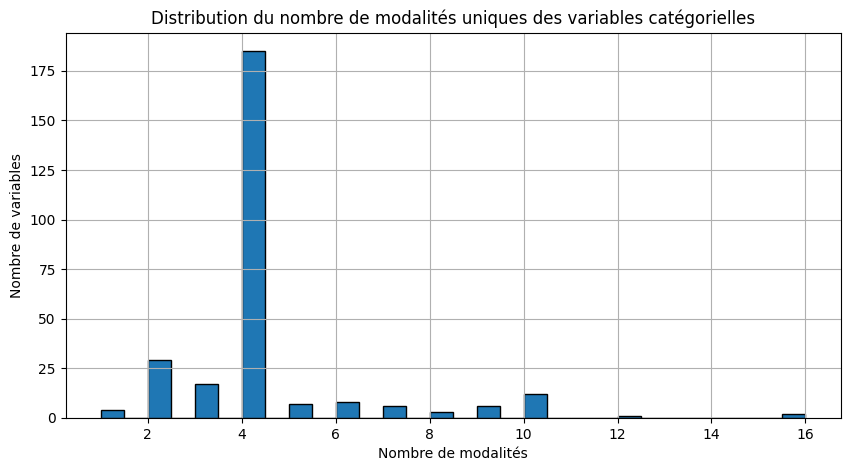

In [10]:
n_modalites = [X_train[col].nunique() for col in categorical_cols]
plt.figure(figsize=(10, 5))
plt.hist(n_modalites, bins=30, edgecolor='black')
plt.title("Distribution du nombre de modalités uniques des variables catégorielles")
plt.xlabel("Nombre de modalités")
plt.ylabel("Nombre de variables")
plt.grid(True)
plt.show()

L’histogramme du nombre de modalités (cf. ci-dessus) permet d’obtenir une **vue d’ensemble** sur la distribution de la cardinalité des variables catégorielles. Il offre une indication globale sur :

- la proportion de variables peu variées (≤ 5 modalités), généralement simples à encoder ;
- l’existence éventuelle de variables à cardinalité élevée, nécessitant des traitements spécifiques.

Cependant, cette représentation ne fournit **aucune information sur l’identité des variables concernées**, ce qui **limite son usage opérationnel**. Il est donc **impossible de cibler des variables précises** à partir de ce graphique.

En conséquence, l’histogramme peut être conservé à titre **illustratif**, mais ne remplace pas une synthèse structurée par variable, qui seule permet de prendre des décisions de prétraitement (encodage, regroupement, exclusion).

Affichons donc le résumé synthétique des variables catégorielles.

In [11]:
# Résumé synthétique des variables catégorielles
summary = []

for col in categorical_cols:
    vc = X_train[col].value_counts(dropna=False)
    top_value = vc.index[0]
    top_freq = vc.iloc[0]
    top_prop = round(top_freq / len(X_train) * 100, 2)
    summary.append({
        'Variable': col,
        'Modalités uniques': X_train[col].nunique(dropna=False),
        'Modalité la plus fréquente': top_value,
        'Fréquence (%)': top_prop
    })

cat_summary_df = pd.DataFrame(summary).sort_values(by='Fréquence (%)', ascending=False)
# Affichage dans une boîte scrollable
html_summary = cat_summary_df.to_html(index=False)
HTML(f"""
<div style="height:400px; overflow-y:scroll; border:1px solid lightgray; padding:10px">
    {html_summary}
</div>
""")

Variable,Modalités uniques,Modalité la plus fréquente,Fréquence (%)
DEROG14,2,NaN,100.00
DEROG1,2,N,99.98
KAPITAL38,2,N,99.96
DEROG7,2,N,99.80
KAPITAL36,2,N,99.77
DEROG13,4,NaN,99.66
DEROG10,2,N,99.62
KAPITAL39,2,N,99.58
DEROG6,2,N,99.48
DEROG9,2,N,99.43


Effectuons une démarche analogue à celle réalisée précédemment pour les variables numériques.

In [ ]:
# Résumé synthétique des variables numériques
summary = []

for col in numerical_cols:
    vc = X_train[col].value_counts(dropna=False)
    top_value = vc.index[0]
    top_freq = vc.iloc[0]
    top_prop = round(top_freq / len(X_train) * 100, 2)
    summary.append({
        'Variable': col,
        'Modalités uniques': X_train[col].nunique(dropna=False),
        'Modalité la plus fréquente': top_value,
        'Fréquence (%)': top_prop
    })

cat_summary_df = pd.DataFrame(summary).sort_values(by='Fréquence (%)', ascending=False)
# Affichage dans une boîte scrollable
html_summary = cat_summary_df.to_html(index=False)
HTML(f"""
<div style="height:400px; overflow-y:scroll; border:1px solid lightgray; padding:10px">
    {html_summary}
</div>
""")

Variable,Modalités uniques,Modalité la plus fréquente,Fréquence (%)
SURFACE20,4,0.0,100.00
DEROG15,2,100.0,99.99
SURFACE14,5,0.0,99.99
SURFACE15,4,0.0,99.99
CA2,3,0.0,99.98
KAPITAL4,2,0.0,99.96
NBBAT3,6,0.0,99.89
KAPITAL2,2,0.0,99.77
NBBAT5,6,0.0,99.73
KAPITAL5,2,0.0,99.58


### Analyse quantitative des variables catégorielles

#### 1. Nombre de modalités
- Il apparaît une **grande hétérogénéité** dans le nombre de modalités :
  - Certaines variables présentent une très forte cardinalité, comme `ANNEE_ASSURANCE` avec 1113 modalités distinctes. Cela peut poser des problèmes en modélisation, notamment pour les algorithmes sensibles à la granularité des données ;
  - À l'inverse, un grand nombre de variables n'ont que **2 à 4 modalités**, comme `ADOSS`, `TYPERS`, `DEROG1`, etc.
- Plus de **150 variables** possèdent **moins de 5 modalités**, ce qui les rend **faciles à encoder** (binaire, label encoding...).
- Une large famille de variables telles que les `DISTANCE_xxx`, `RR_xxx`, `NBJ_xxx`, `FXI_xxx`, `TMM/TX/TN_xxx` ont souvent **4 classes ordinales** correspondant à des intervalles de valeurs (souvent par quartiles).

#### 2. Distribution déséquilibrée
- Beaucoup de variables présentent une **forte domination d'une modalité** :
  - Exemple : `DEROG1` → 99.98% de "N", 0.02% de "O".
  - `KAPITAL38` → 99.96% de "N".
- D'autres variables comme `ACTIVIT2`, `VOCATION`, `CARACT4`, `MEN_1IND` sont déséquilibrées mais exploitables.

#### 3. Présence de modalités rares
- Certaines modalités apparaissent **moins de 10 fois** :
  - Cela peut poser des problèmes de **sur-apprentissage** et **brouiller le signal** dans les modèles.
  - Exemples : `DEROG14`, `DISTANCE_244`, certaines modalités de `MEN_PROP`.

#### 4. Codages textuels ordonnés
- De nombreuses variables sont issues de **discrétisation d'une variable continue** :
  - Exemples de modalités : `01. <= 10`, `04. >= 40`, etc.
  - Ces variables conservent une **structure ordinale** exploitable :
    - **Encodage ordinal**
    - Ou **reconversion en continu** via la borne médiane

#### 5. Familles de variables cohérentes
- Plusieurs familles homogènes peuvent être identifiées :
  - `DISTANCE_xxx` : distances en classes (4-5 modalités).
  - `NBJxxx_MM/MSOM/MMAX` : séries météo discrétisées.
  - `PROPORTION_xx`, `MEN_xxx`, `KAPITALxx`, `DEROGxx` : codifications internes.
- Ces regroupements permettent une **ingénierie de variables pertinente** :
  - Moyennes ou scores internes
  - Réduction de dimension (ACP)
  - Agrégation par famille

### Implications pour la modélisation

- **Variables peu informatives** ou trop déséquilibrées :
  - À écarter ou traiter spécifiquement.
  - Ex : `DEROG14`, `IND_INC`, `DISTANCE_244` ;

- **Variables ordinales exploitables** :
  - Les variables comme `DISTANCE`, `METEO`, `PROPORTION`, etc., sont **structurées pour un encodage ordonné ou continu** ;

- **Variables très dispersées** :
  - Ex : `ANNEE_ASSURANCE`, `ZONE`
  - Nécessitent un traitement spécifique : **groupement**, **encodage fréquence**, ou **embedding** selon le modèle.

L'approche implémentée ici repose sur une stratégie **différenciée selon la nature et la complétude des variables**, avec les objectifs suivants :

- **Préserver l'information existante** dans les colonnes peu affectées par des valeurs manquantes ;
- **Limiter la distorsion** causée par l'imputation dans les colonnes fortement incomplètes ;
- **Permettre au modèle d'apprendre** à partir du fait qu'une valeur était absente, en créant une modalité explicite (`'missing'`) pour les variables catégorielles très incomplètes ;

#### Logique appliquée :
- **Variables numériques :**
  - Si moins de 30% de valeurs manquantes → imputation par la **médiane** (robuste aux outliers) ;
  - Si plus de 30% de valeurs manquantes → imputation conservatrice par **zéro**, considérée comme une absence de valeur pertinente.

- **Variables catégorielles :**
  - Si moins de 30% de valeurs manquantes → imputation par la **valeur la plus fréquente** (mode);
  - Si plus de 30% de valeurs manquantes → imputation par une valeur explicite `'missing'`, interprétable comme une modalité à part entière.

Cette stratégie permet une **modélisation plus robuste**, tout en **évitant de supprimer prématurément des variables potentiellement informatives** malgré leur incomplétude.



In [ ]:
print('ID' in X_train.columns.tolist())

True


In [21]:
# Séparation colonnes numériques / catégorielles
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# 1. Colonnes numériques
# a. Colonnes avec peu de valeurs manquantes (<30%) → imputation par la médiane
low_na_num = [col for col in num_cols if X_train[col].isna().mean() < 0.3]
# b. Colonnes très incomplètes (>=30%) → imputation conservatrice par constante (0)
high_na_num = [col for col in num_cols if X_train[col].isna().mean() >= 0.3]

X_train[low_na_num] = SimpleImputer(strategy='median').fit_transform(X_train[low_na_num])
X_train[high_na_num] = X_train[high_na_num].fillna(0)

# 2. Colonnes catégorielles
# a. Colonnes avec peu de NaN → imputation par la valeur la plus fréquente (mode)
low_na_cat = [col for col in cat_cols if X_train[col].isna().mean() < 0.3]
# b. Colonnes très incomplètes → imputation par 'missing' (valeur explicite)
high_na_cat = [col for col in cat_cols if X_train[col].isna().mean() >= 0.3]

X_train[low_na_cat] = SimpleImputer(strategy='most_frequent').fit_transform(X_train[low_na_cat])
X_train[high_na_cat] = X_train[high_na_cat].fillna('missing')

Avant d'entraîner un modèle, il est essentiel d'écarter certaines variables qui **n'apportent pas d'information pertinente pour la prédiction**, ou qui pourraient **introduire du bruit ou des fuites de données** :

- **`ID`** :  
  - Identifiant unique de la ligne ou de l'observation ;
  - **Sans signification statistique** : il n'est pas corrélé à la cible et risque d'être utilisé à tort par un modèle non régularisé comme un pseudo-prédicteur.
  - Peut **induire du surapprentissage** si laissé dans les données.

- **`ANNEE_ASSURANCE`** :  
  - Variable qui peut être fortement **corrélée avec la date de déclaration**, de souscription ou avec le risque (biais temporel).
  - Si la modélisation est censée être **générique et prédictive hors période**, cette colonne introduit un **risque de fuite temporelle**.
  - À moins de construire un modèle par période ou de vouloir capter des effets saisonniers ou historiques, il est préférable de la supprimer.

> Ces suppressions participent à la **robustesse** du modèle en limitant l'apprentissage sur des artefacts sans valeur prédictive réelle.

In [ ]:
# Suppression des colonnes inutiles
X_train = X_train.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)

# Encodage des variables catégoriques avec CountEncoder
encoder = CountEncoder(cols=cat_cols)
encoder.fit(X_train)
X_train_enc = encoder.transform(X_train)

### Graphe de distribution de la variable cible `CM` (coût moyen)

Le graphe de distribution de la variable cible s'inscrit dans trois objectifs :
- Détection de la distribution (loi normale, asymétrique, etc.) : Si la distribution est fortement asymétrique , cela peut indiquer qu'une transformation sera nécessaire pour améliorer les performances du modèle ;
- Identification d'éventuelles valeurs extrêmes (*outliers*) : Les éléments isolés à l'extrémité du graphique révèlent des valeurs atypiques, qui peuvent biaiser l'apprentissage si non traitées ;
- Ajustement du modèle et du choix de la métrique : Une distribution très déséquilibrée ou avec des zéros majoritaires peut influencer le choix de la fonction de perte ou des stratégies de rééchantillonnage.


In [ ]:
# Graphe de distribution de y_train['CM']

plt.figure(figsize=(10, 6))
sns.histplot(y_train['CM'], kde=True)
plt.title('Distribution of CM')
plt.xlabel('CM')
plt.ylabel('Frequency')
plt.show()

La distribution du coût moyen (CM) présente les caractéristiques suivantes :

- Distribution extrêmement asymétrique à droite :
  - Une immense majorité des valeurs de CM sont proches de zéro ;
  - Quelques valeurs atteignent des niveaux très élevés (jusqu'à près de 500000), mais elles sont très rares.

- Concentration des observations :
  - Plus de 3 millions d'observations se situent dans l'intervalle 0 à quelques milliers d'euros, ce qui indique une forte concentration autour de petites valeurs ;
  - Cela suggère que la majorité des sinistres ont un coût moyen faible.

- Présence de valeurs extrêmes (outliers) :
  - Quelques sinistres présentent un coût exceptionnellement élevé.
  - Ces valeurs ont un poids potentiel important dans le calcul des métriques(RMSE, MAE…) et peuvent biaisser l'entraînement si non traitées.

L'examen de la distribution brute de `CM` révèle une **forte asymétrie à droite** : la majorité des valeurs sont très faibles (proches de zéro), tandis qu'une minorité présente des montants exceptionnellement élevés.

Ce comportement est typique des variables de type **coût de sinistres** ou **montants financiers**, souvent modélisées avec des **lois de Pareto**, **log-normales** ou **gamma**.

Une transformation logarithmique `log(CM + 1)` permettrait de :
  - Réduire l'effet des *outliers* ;
  - Rapprocher la distribution d'une loi normale, facilitant la modélisation ;
  - Améliorer la performance des modèles sensibles à la distribution.

In [ ]:
# Transformation log(CM + 1) pour réduire la variance et la dissymétrie
y_train['CM_log'] = np.log1p(y_train['CM'])  # log1p(x) = log(x + 1)

plt.figure(figsize=(10, 6))
sns.histplot(y_train['CM_log'], kde=True, bins=50)
plt.title('Distribution de log(CM + 1)')
plt.xlabel('log(CM + 1)')
plt.ylabel('Fréquence')
plt.show()


Même après transformation `log(CM + 1)`, la distribution reste ultra-concentrée autour de zéro, ce qui n'est pas l'effet attendu d'un `log-transform`. Cela suggère fortement que **la majorité des valeurs de CM sont nulles ou quasi-nulles**.
Vérifions cette hypothèse en deux temps :
1. Vérifier la proportion de zéros

In [ ]:
zero_ratio = (y_train['CM'] == 0).mean()
print(f"Proportion de zéros dans CM : {zero_ratio:.2%}")

2. Affiche la distribution sans les zéros

In [ ]:
non_zero_cm = y_train[y_train['CM'] > 0]['CM']
log_non_zero_cm = np.log1p(non_zero_cm)

plt.figure(figsize=(10, 6))
sns.histplot(log_non_zero_cm, kde=True, bins=50)
plt.title("Distribution de log(CM + 1) pour CM > 0")
plt.xlabel("log(CM + 1)")
plt.ylabel("Fréquence")
plt.show()

Plusieur éléments se dégagent de la transformation logarithmique sur les observations strictement positives (`CM > 0`) :

1. **Réduction de l'asymétrie**  
   La transformation logarithmique a permis de corriger l'asymétrie extrême initialement observée dans la distribution brute de `CM`. Elle :
   - compresse l'effet des très grandes valeurs (*outliers*),
   - met mieux en évidence la structure sous-jacente des montants courants.

2. **Distribution toujours asymétrique à droite**  
   Malgré la transformation, la distribution reste légèrement étalée vers la droite, ce qui reflète la nature typiquement déséquilibrée des montants de sinistres (une majorité de petits montants, quelques très gros).

3. Le mode, qui constitue la valeur la plus fréquente dans une série de données, se situe autour de `log(CM + 1) ≈ 6`: Cela correspond à un coût de sinistre typique de `exp(6) - 1 ≈ 400 €`, valeur qui semble représenter un sinistre "standard" dans le jeu de données.

Nous pouvons en déduire que cette transformation rend la variable cible plus adaptée à une régression, notamment linéaire, en :
  - réduisant la variance,
  - limitant le poids des valeurs extrêmes,
  - facilitant la convergence des modèles.

- Elle améliore également la **robustesse** des algorithmes face aux déséquilibres structurels inhérents aux données assurantielles.

> Cette transformation est particulièrement utile dans une stratégie en deux étapes :  
> 1. modèle binaire de prédiction de la survenue d'un sinistre (`CM > 0`),  
> 2. régression sur `log(CM + 1)` conditionnée à `CM > 0`.

In [ ]:
# 1. Création de la cible binaire (sinistre ou non)
y_train_bin = (y_train['CM'] > 0).astype(int)

# Séparation des données pour la phase de test
X_tr, X_val, y_bin_tr, y_bin_val = train_test_split(X_train_enc, y_train_bin, test_size=0.2, random_state=42)

# 2. Étape 1 - Modèle de classification binaire : prédire si CM > 0
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_bin_tr)

# Prédictions de probabilité d’avoir un sinistre
proba_sinistre = clf.predict_proba(X_val)[:, 1]

# Évaluation du modèle binaire
auc = roc_auc_score(y_bin_val, proba_sinistre)
print(f"AUC (CM > 0): {auc:.4f}")

# 3. Étape 2 - Modèle de régression conditionnelle sur CM > 0
# Filtrage sur les cas avec sinistre
X_train_pos = X_train_enc[y_train['CM'] > 0]
y_train_logcm = np.log1p(y_train['CM'][y_train['CM'] > 0])

# Séparation pour validation
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train_pos, y_train_logcm, test_size=0.2, random_state=42)

# Régression sur log(CM + 1)
reg = Ridge(alpha=1.0)
reg.fit(X_tr2, y_tr2)

# Prédictions
y_pred_log = reg.predict(X_val2)
rmse = mean_squared_error(y_val2, y_pred_log)
print(f"RMSE sur log(CM + 1): {rmse:.4f}")


#### Analyse des performances du modèle

#### 1. AUC (CM > 0) = **0.7371**

L'AUC (*Area Under the Curve*) évalue la capacité du modèle à distinguer les observations où `CM > 0` (existence d'un sinistre) de celles où `CM = 0` (absence de sinistre).  
Une AUC de **0.7371** indique une **bonne performance de discrimination** :  
- Le modèle parvient à capter un signal pertinent.
- Il est significativement meilleur que le hasard (AUC = 0.5).
- Cela ouvre la voie à des **applications utiles pour le scoring ou la priorisation du risque**.

#### 2. RMSE sur `log(CM + 1)` = **5.5240**

Le RMSE est calculé ici sur la transformation logarithmique `log(CM + 1)`, souvent utilisée pour réduire l'impact des outliers dans une distribution très asymétrique.  
Une erreur de 5.5240 en log se traduit par une erreur moyenne d’environ :

$$
e^{5.5240} - 1 \approx 250 \text{ €}
$$

Cela signifie qu'en moyenne, le modèle se trompe d'environ 250 € sur la prédiction du coût sinistre.  
C'est une erreur significative si la plupart des sinistres sont faibles, mais raisonnable si la distribution comporte de nombreux sinistres très élevés.

Ainsi :

- Le modèle **discrimine correctement** la survenue d'un sinistre (AUC satisfaisante).
- L'estimation du coût (RMSE) est perfectible, probablement à cause de la **présence d’outliers** importants.
- Des améliorations possibles :
  - Approche **en deux étapes** : classification (CM > 0) + régression sur les cas sinistrés.
  - Utilisation de modèles **robustes aux valeurs extrêmes**.
  - Test de **transformations alternatives** ou pondérations adaptées au domaine assurantiel.
